# COVID19 DRUG DISCOVERY

The data for this project was taken from kaggle: https://www.kaggle.com/divyansh22/drug-discovery-data

The goal of this project is to determine if any of these compounds are active against COVID19 based upon experimental data and engineered features using pubchempy. Additionally, we will use machine learning methods to predict the pIC50 values of blinded compounds based upon the aforementioned features.

## COVID19 Drug Discovery efforts and understanding

COVID19 has had substantial impacts on the world, affecting the livelihoods of families, economies of all nations, with almost 6 million deaths worldwide since it's appearance in 2020. While vaccines have been effective in reducing disease severity upon infection, the safety of these vaccines and the policies surrounding their administration continue to be a source of fierce debate. As with any pandemic, efforts towards finding small molecule therapeutics remained at the forefront of combating this disease. This dataset contains experimental and engineered data features for over 100 compounds. 

Many features in the dataset are crucial for determining how well these compounds act against COVID19. pIC50 and XlogP are the typical hallmark pharmacological variables that indicate how effective a compound will be as a potential therapeutic. pIC50 is the logrithimic transformation of IC50, which determines the concentration necessary to inhibit 50% of the activity of the drug target or the targeted biological process. LogP is a measure of lipophlicity which is used to determine how well the drug will be absorbed by the body. IC50s in the nanomolar (nM) or picomolar (pM) ranges are usually considered to be very active compounds, while certain LogP values are optimal dependent upon how the drug will be administered. Oral, subcutaneous, rectal, and injectible routes of drug administration all have optimal LogP values that determine the best route of administration. 

The engineered dataset values such as HBondDonorCount, FeatureCounts, etc all hold key information about the drug structure itself that could potentially influence it's activity. The presence of Hydrogen bond donors and acceptors, as well as features releated to stereochemistry (StereoCounts) can affect how well the target binds to the drug.

Finally, certain features don't impact drug activity at all (Molecular formula, Weight, SMILES, CID, etc). While these are important features for describing general characteristics of the compound, they are not effective predictors of drug efficacy and will likely not be a part of the predictive model. 

In [1]:
#!pip install pubchempy

In [2]:
#import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
import pubchempy as pcp

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('DDH Data with Properties.csv', sep=",", header=0)
df.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CID                       104 non-null    int64  
 1   SMILES                    104 non-null    object 
 2   MolecularFormula          104 non-null    object 
 3   MolecularWeight           104 non-null    float64
 4   InChI                     104 non-null    object 
 5   InChIKey                  101 non-null    object 
 6   IUPACName                 101 non-null    object 
 7   XLogP                     101 non-null    float64
 8   ExactMass                 101 non-null    float64
 9   MonoisotopicMass          101 non-null    float64
 10  TPSA                      101 non-null    float64
 11  Complexity                101 non-null    float64
 12  Charge                    101 non-null    float64
 13  HBondDonorCount           101 non-null    float64
 14  HBondAccep

In [5]:
df.shape

(104, 40)

In [6]:
df.isna().sum()

CID                         0
SMILES                      0
MolecularFormula            0
MolecularWeight             0
InChI                       0
InChIKey                    3
IUPACName                   3
XLogP                       3
ExactMass                   3
MonoisotopicMass            3
TPSA                        3
Complexity                  3
Charge                      3
HBondDonorCount             3
HBondAcceptorCount          3
RotatableBondCount          3
HeavyAtomCount              3
IsotopeAtomCount            3
AtomStereoCount             3
DefinedAtomStereoCount      3
UndefinedAtomStereoCount    3
BondStereoCount             3
DefinedBondStereoCount      3
UndefinedBondStereoCount    3
CovalentUnitCount           3
Volume3D                    3
XStericQuadrupole3D         4
YStericQuadrupole3D         4
ZStericQuadrupole3D         4
FeatureCount3D              4
FeatureAcceptorCount3D      4
FeatureDonorCount3D         4
FeatureAnionCount3D         4
FeatureCat

### Insight:
SMILES, molecular formula, InChI, key, and IUPAC name are not important indicators for compound efficacy. will drop from df.

In [7]:
df2 = df.drop(['SMILES', 'MolecularFormula', 'InChI', 'InChIKey', 'IUPACName'], axis=1)
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,519.1,6.3,518.013024,518.013024,175.0,635.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [8]:
df2.columns

Index(['CID', 'MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass',
       'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

In [9]:
#create df with blinded values

blinded_df = df2[df2['pIC50'] == 'BLINDED']

blinded_df        

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
3,2820914,519.10,6.3,518.013024,518.013024,175.0,635.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
22,135427623,437.40,2.5,437.079390,437.079390,175.0,835.0,0.0,2.0,8.0,...,6.0,2.0,1.0,0.0,3.0,0.0,1.0,8.0,10.0,BLINDED
27,164676,294.30,4.3,294.125594,294.125594,47.3,509.0,0.0,0.0,3.0,...,3.0,0.0,0.0,0.0,4.0,1.0,0.6,0.8,1.0,BLINDED
41,2799801,494.50,4.4,494.126006,494.126006,167.0,935.0,0.0,2.0,10.0,...,6.0,2.0,0.0,2.0,2.0,0.0,1.2,12.0,10.0,BLINDED
45,2799800,588.60,5.4,588.177766,588.177766,172.0,946.0,0.0,2.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLINDED
57,16204323,379.10,4.4,377.981027,377.981027,98.2,503.0,0.0,0.0,6.0,...,5.0,0.0,1.0,0.0,3.0,0.0,1.0,5.0,10.0,BLINDED
62,16202740,268.09,3.5,266.985384,266.985384,39.2,267.0,0.0,0.0,3.0,...,2.0,0.0,0.0,0.0,2.0,0.0,0.6,3.0,10.0,BLINDED
67,58589722,309.34,-0.4,309.078327,309.078327,95.2,548.0,0.0,1.0,6.0,...,4.0,1.0,0.0,1.0,3.0,0.0,0.6,3.4,10.0,BLINDED
73,4117383,294.33,0.6,294.067428,294.067428,91.9,519.0,0.0,1.0,5.0,...,4.0,1.0,0.0,0.0,3.0,0.0,0.6,3.4,10.0,BLINDED
94,44398167,421.18,3.0,420.981100,420.981100,55.8,499.0,0.0,0.0,4.0,...,4.0,0.0,0.0,0.0,4.0,1.0,0.6,3.0,10.0,BLINDED


In [10]:
blinded_df.shape

(10, 35)

In [11]:
#removing blinded pIC50 values from main dataframe

df2 = df2.loc[df2['pIC50'] != 'BLINDED']
df2.shape

(94, 35)

In [12]:
#removing rows where CID=0

df2 = df2.loc[df2['CID'] != 0]
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
4,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
5,2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [13]:
df2.shape

(91, 35)

In [14]:
df2.isnull().values.any()

False

In [15]:
#setting CID as index so values do not interfere with analysis

df2.set_index(df2['CID'], inplace=True)
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [16]:
#dropping CID as a feature

df2.drop('CID', axis=1, inplace=True)
df2.head()

,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,7.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,6.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [17]:
df2.columns

Index(['MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA',
       'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

In [18]:
for x in df2.columns:
    print(df2.value_counts(x))

MolecularWeight
344.70    3
322.40    2
234.64    2
278.65    2
399.50    2
         ..
338.30    1
334.40    1
334.10    1
331.30    1
565.00    1
Length: 83, dtype: int64
XLogP
 4.1    7
 3.3    5
 3.8    5
 2.7    4
 4.9    4
 4.7    4
 3.7    4
 2.8    3
 1.1    3
 1.2    3
 1.4    3
 4.6    3
 1.8    3
 3.6    2
 3.4    2
-0.6    2
 3.9    2
 5.9    2
 4.4    2
 3.2    2
 1.6    2
 2.3    2
 1.5    2
 3.1    1
 6.3    1
 0.2    1
 5.6    1
 5.5    1
 5.0    1
 0.7    1
 1.0    1
 4.5    1
 4.2    1
-0.5    1
 1.7    1
 4.0    1
 2.2    1
 2.4    1
 2.5    1
 3.5    1
 2.6    1
 2.9    1
 7.3    1
dtype: int64
ExactMass
344.019999    3
322.098728    2
278.009434    2
234.019605    2
399.125277    2
             ..
338.036128    1
334.055818    1
332.995948    1
331.062677    1
563.814325    1
Length: 83, dtype: int64
MonoisotopicMass
344.019999    3
322.098728    2
278.009434    2
234.019605    2
399.125277    2
             ..
338.036128    1
334.055818    1
332.995948    1
331.06

### Insight
Some of these features don't have any effect on drug action (Mass, molecular weight) and others only have one value for every molecule listed (Charge, isotopeatomcount, etc). These features will be dropped from the dataset, as they don't have a substantial effect on drug efficacy.

In [19]:
#drop columns with only one value and columns that don't contribute to drug action.

todrop = ['MolecularWeight', 'ExactMass', 'MonoisotopicMass', 'Charge', 'IsotopeAtomCount', 'DefinedAtomStereoCount', 
          'UndefinedBondStereoCount', 'CovalentUnitCount']

df2.drop(todrop, axis=1, inplace=True)
df2.shape

(91, 26)

In [20]:
df2.head(10)

,XLogP,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,AtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,5.6,121.0,559.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,4.9,126.0,670.0,1.0,9.0,6.0,33.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,6.3,175.0,627.0,1.0,8.0,7.0,32.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,4.4,162.0,554.0,1.0,8.0,6.0,29.0,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,4.4,106.0,529.0,1.0,6.0,6.0,29.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259
2745640,5.9,106.0,687.0,1.0,9.0,6.0,34.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,8.0,10.0,-1.176091259
2745653,5.0,106.0,567.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259
16075059,4.7,80.2,354.0,1.0,4.0,6.0,22.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,2.0,1.0,0.8,7.0,10.0,-1.477121255
135411083,1.2,197.0,955.0,3.0,9.0,7.0,32.0,0.0,0.0,0.0,...,6.0,3.0,0.0,0.0,3.0,0.0,1.2,8.0,10.0,-1.602059991


In [27]:
#convert pIC50 to numeric

df2['pIC50'] = pd.to_numeric(df2['pIC50'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 2744814 to 44398436
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   XLogP                     91 non-null     float64
 1   TPSA                      91 non-null     float64
 2   Complexity                91 non-null     float64
 3   HBondDonorCount           91 non-null     float64
 4   HBondAcceptorCount        91 non-null     float64
 5   RotatableBondCount        91 non-null     float64
 6   HeavyAtomCount            91 non-null     float64
 7   AtomStereoCount           91 non-null     float64
 8   UndefinedAtomStereoCount  91 non-null     float64
 9   BondStereoCount           91 non-null     float64
 10  DefinedBondStereoCount    91 non-null     float64
 11  Volume3D                  91 non-null     float64
 12  XStericQuadrupole3D       91 non-null     float64
 13  YStericQuadrupole3D       91 non-null     float64
 14  

## EDA of Features

Now that we have a clean dataset, we will explore the data and look for collinearity and other trends.

In [21]:
df2.columns

Index(['XLogP', 'TPSA', 'Complexity', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'AtomStereoCount',
       'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount',
       'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D',
       'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D',
       'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D',
       'FeatureRingCount3D', 'FeatureHydrophobeCount3D',
       'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D',
       'pIC50'],
      dtype='object')

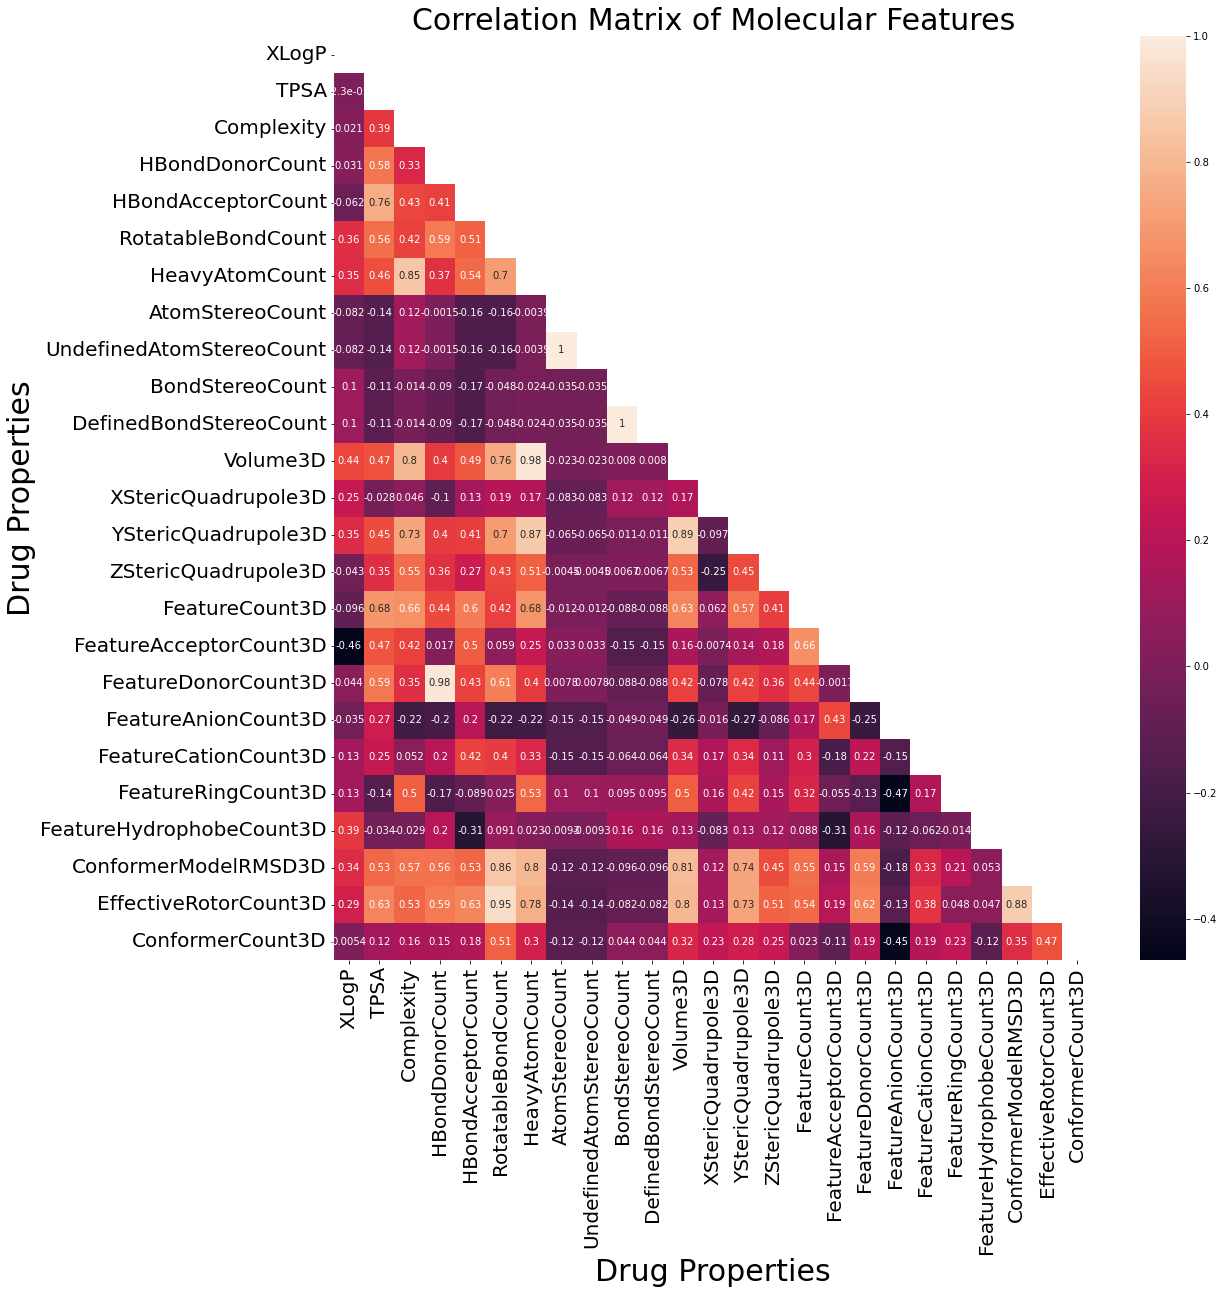

In [22]:
#plot correlation matrix to detect multicollinearity of features

corrmatrix = df2.corr()
matrix = np.triu(corrmatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrmatrix, annot=True, mask=matrix)

# label plot
plt.title('Correlation Matrix of Molecular Features', size=30)
plt.xlabel('Drug Properties', size=30)
plt.ylabel('Drug Properties', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

### Insight
Some of these features are highly correlated (r > 0.7), which can cause problems for potential regression analysis

In [23]:
#function to draw histograms of the features to determine their distribution

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(30, 25))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    plt.show()




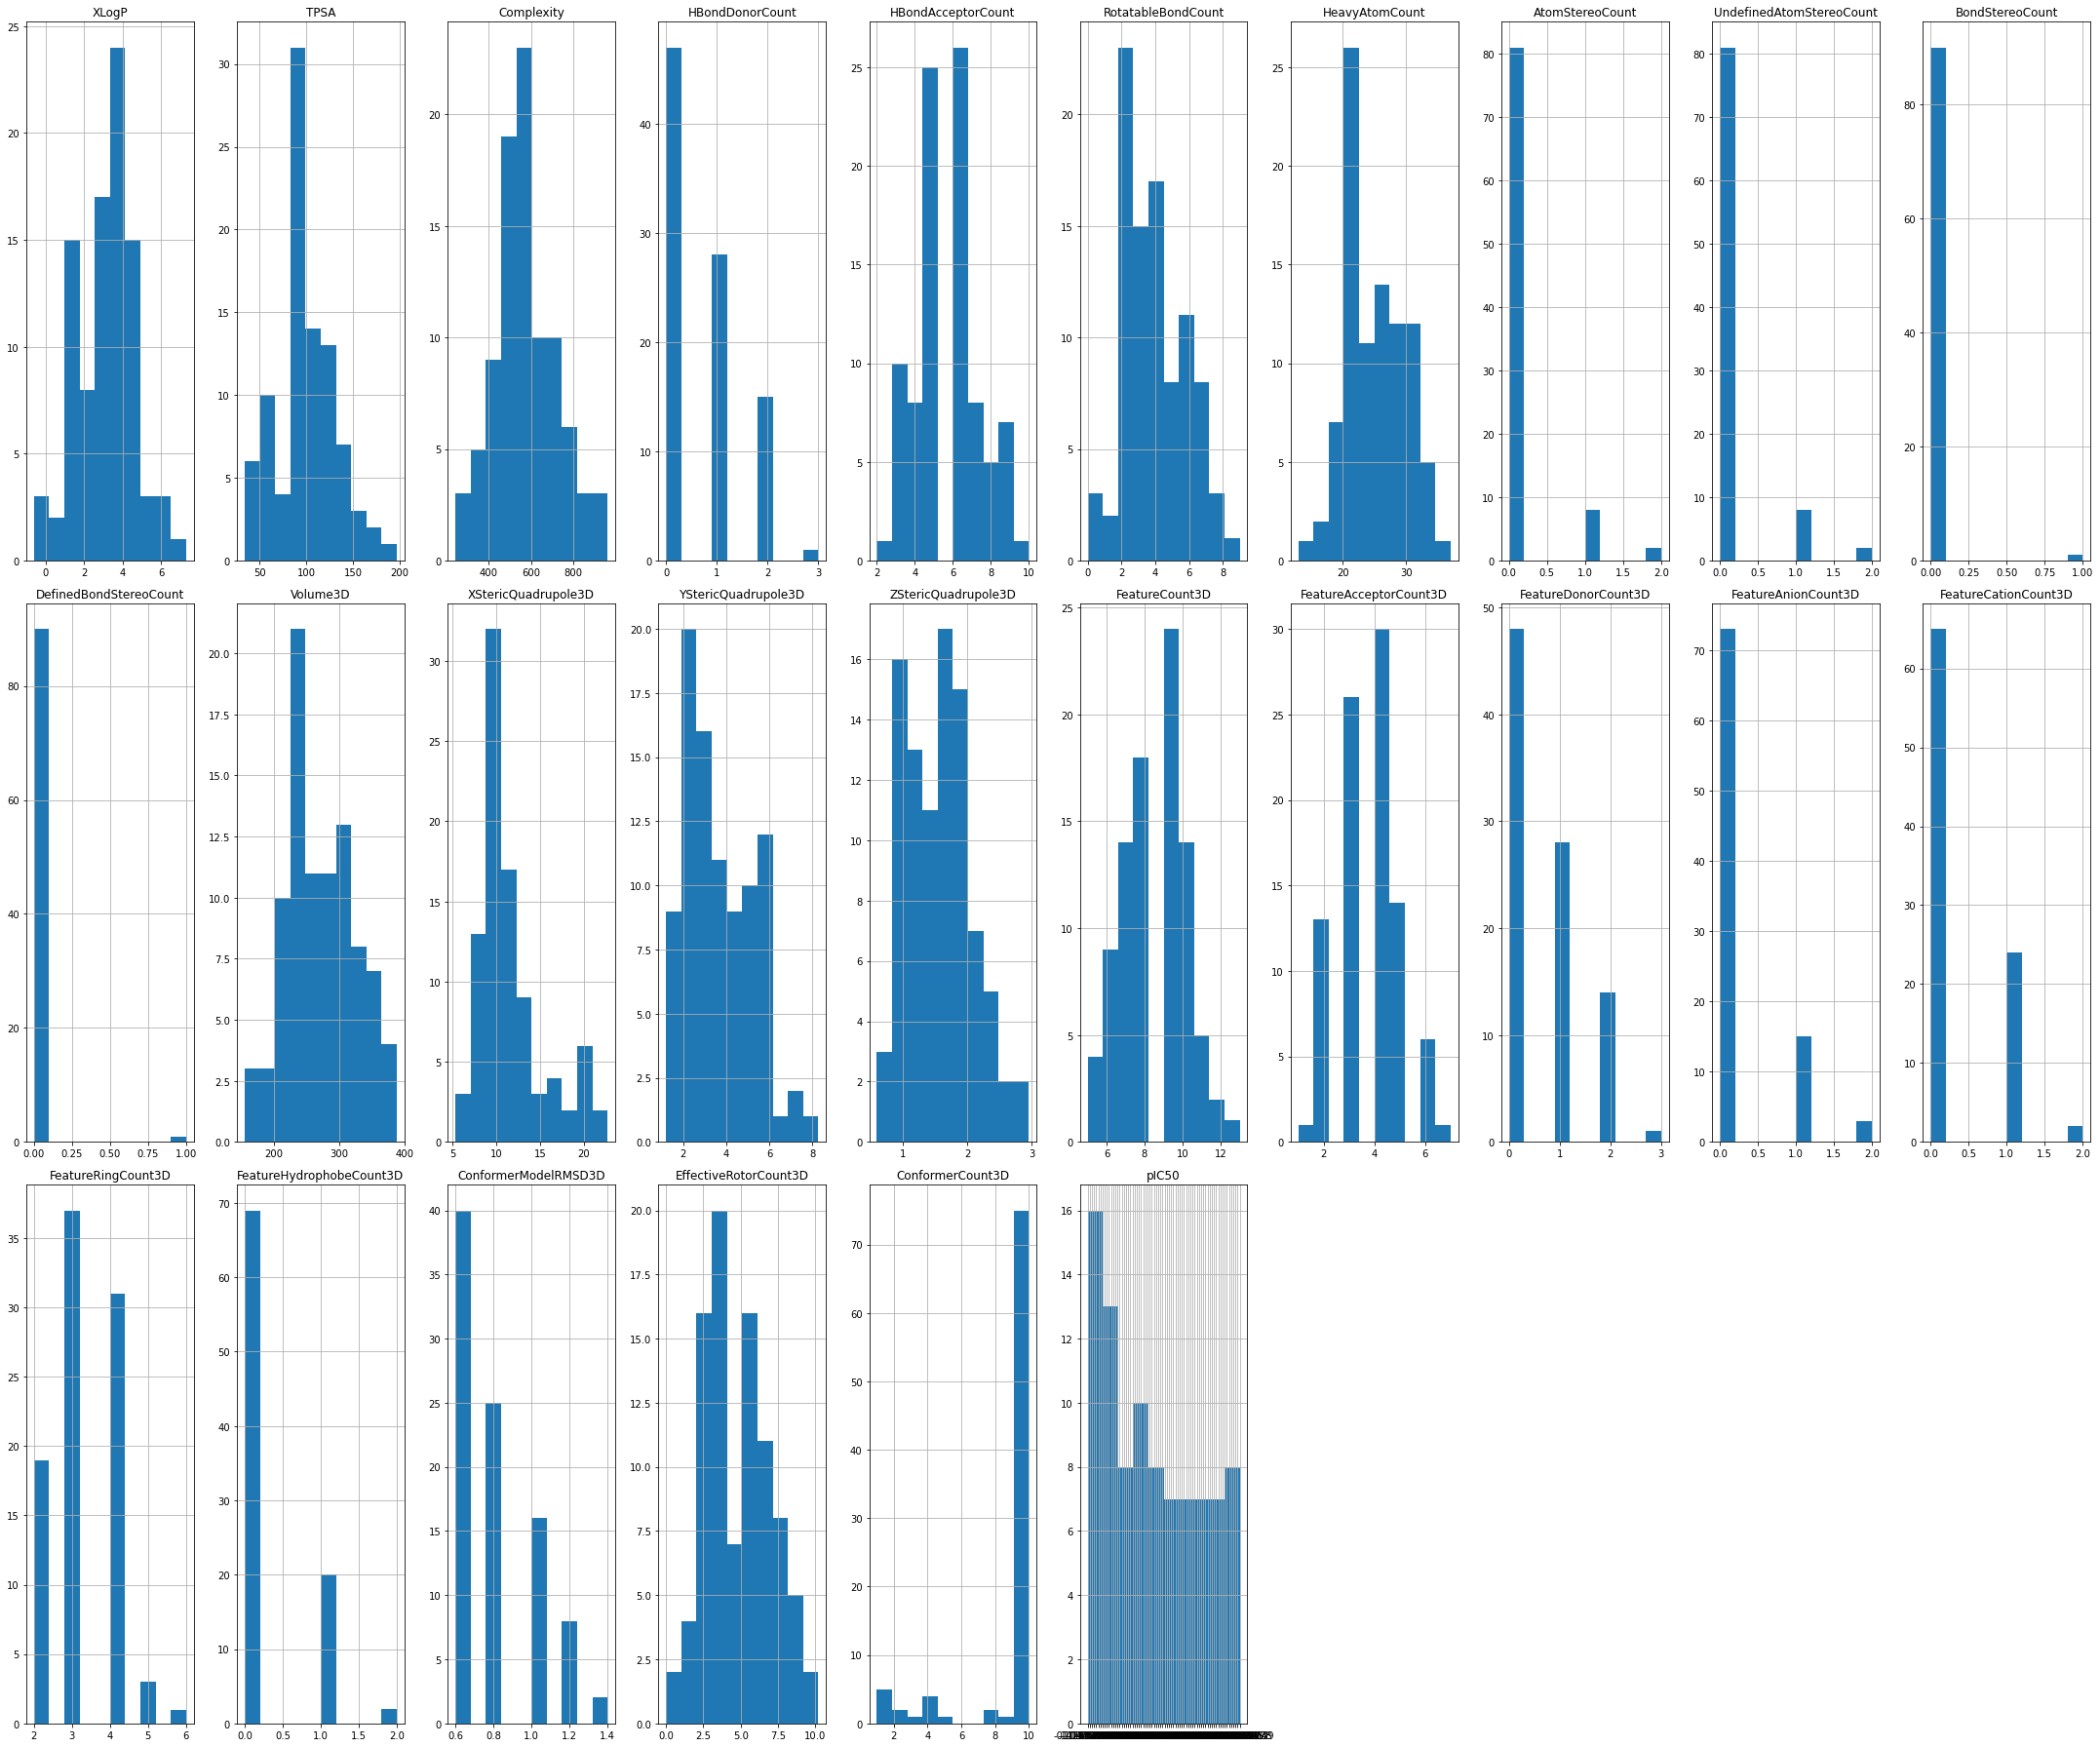

In [24]:
draw_histograms(df2, df2.columns, 3, 10)

***Are there many outliers in the data?***

In [28]:
#function to draw boxplots to check for outliers in features

def draw_boxplots(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(30, 25))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df.boxplot(var_name, ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    plt.show()
    


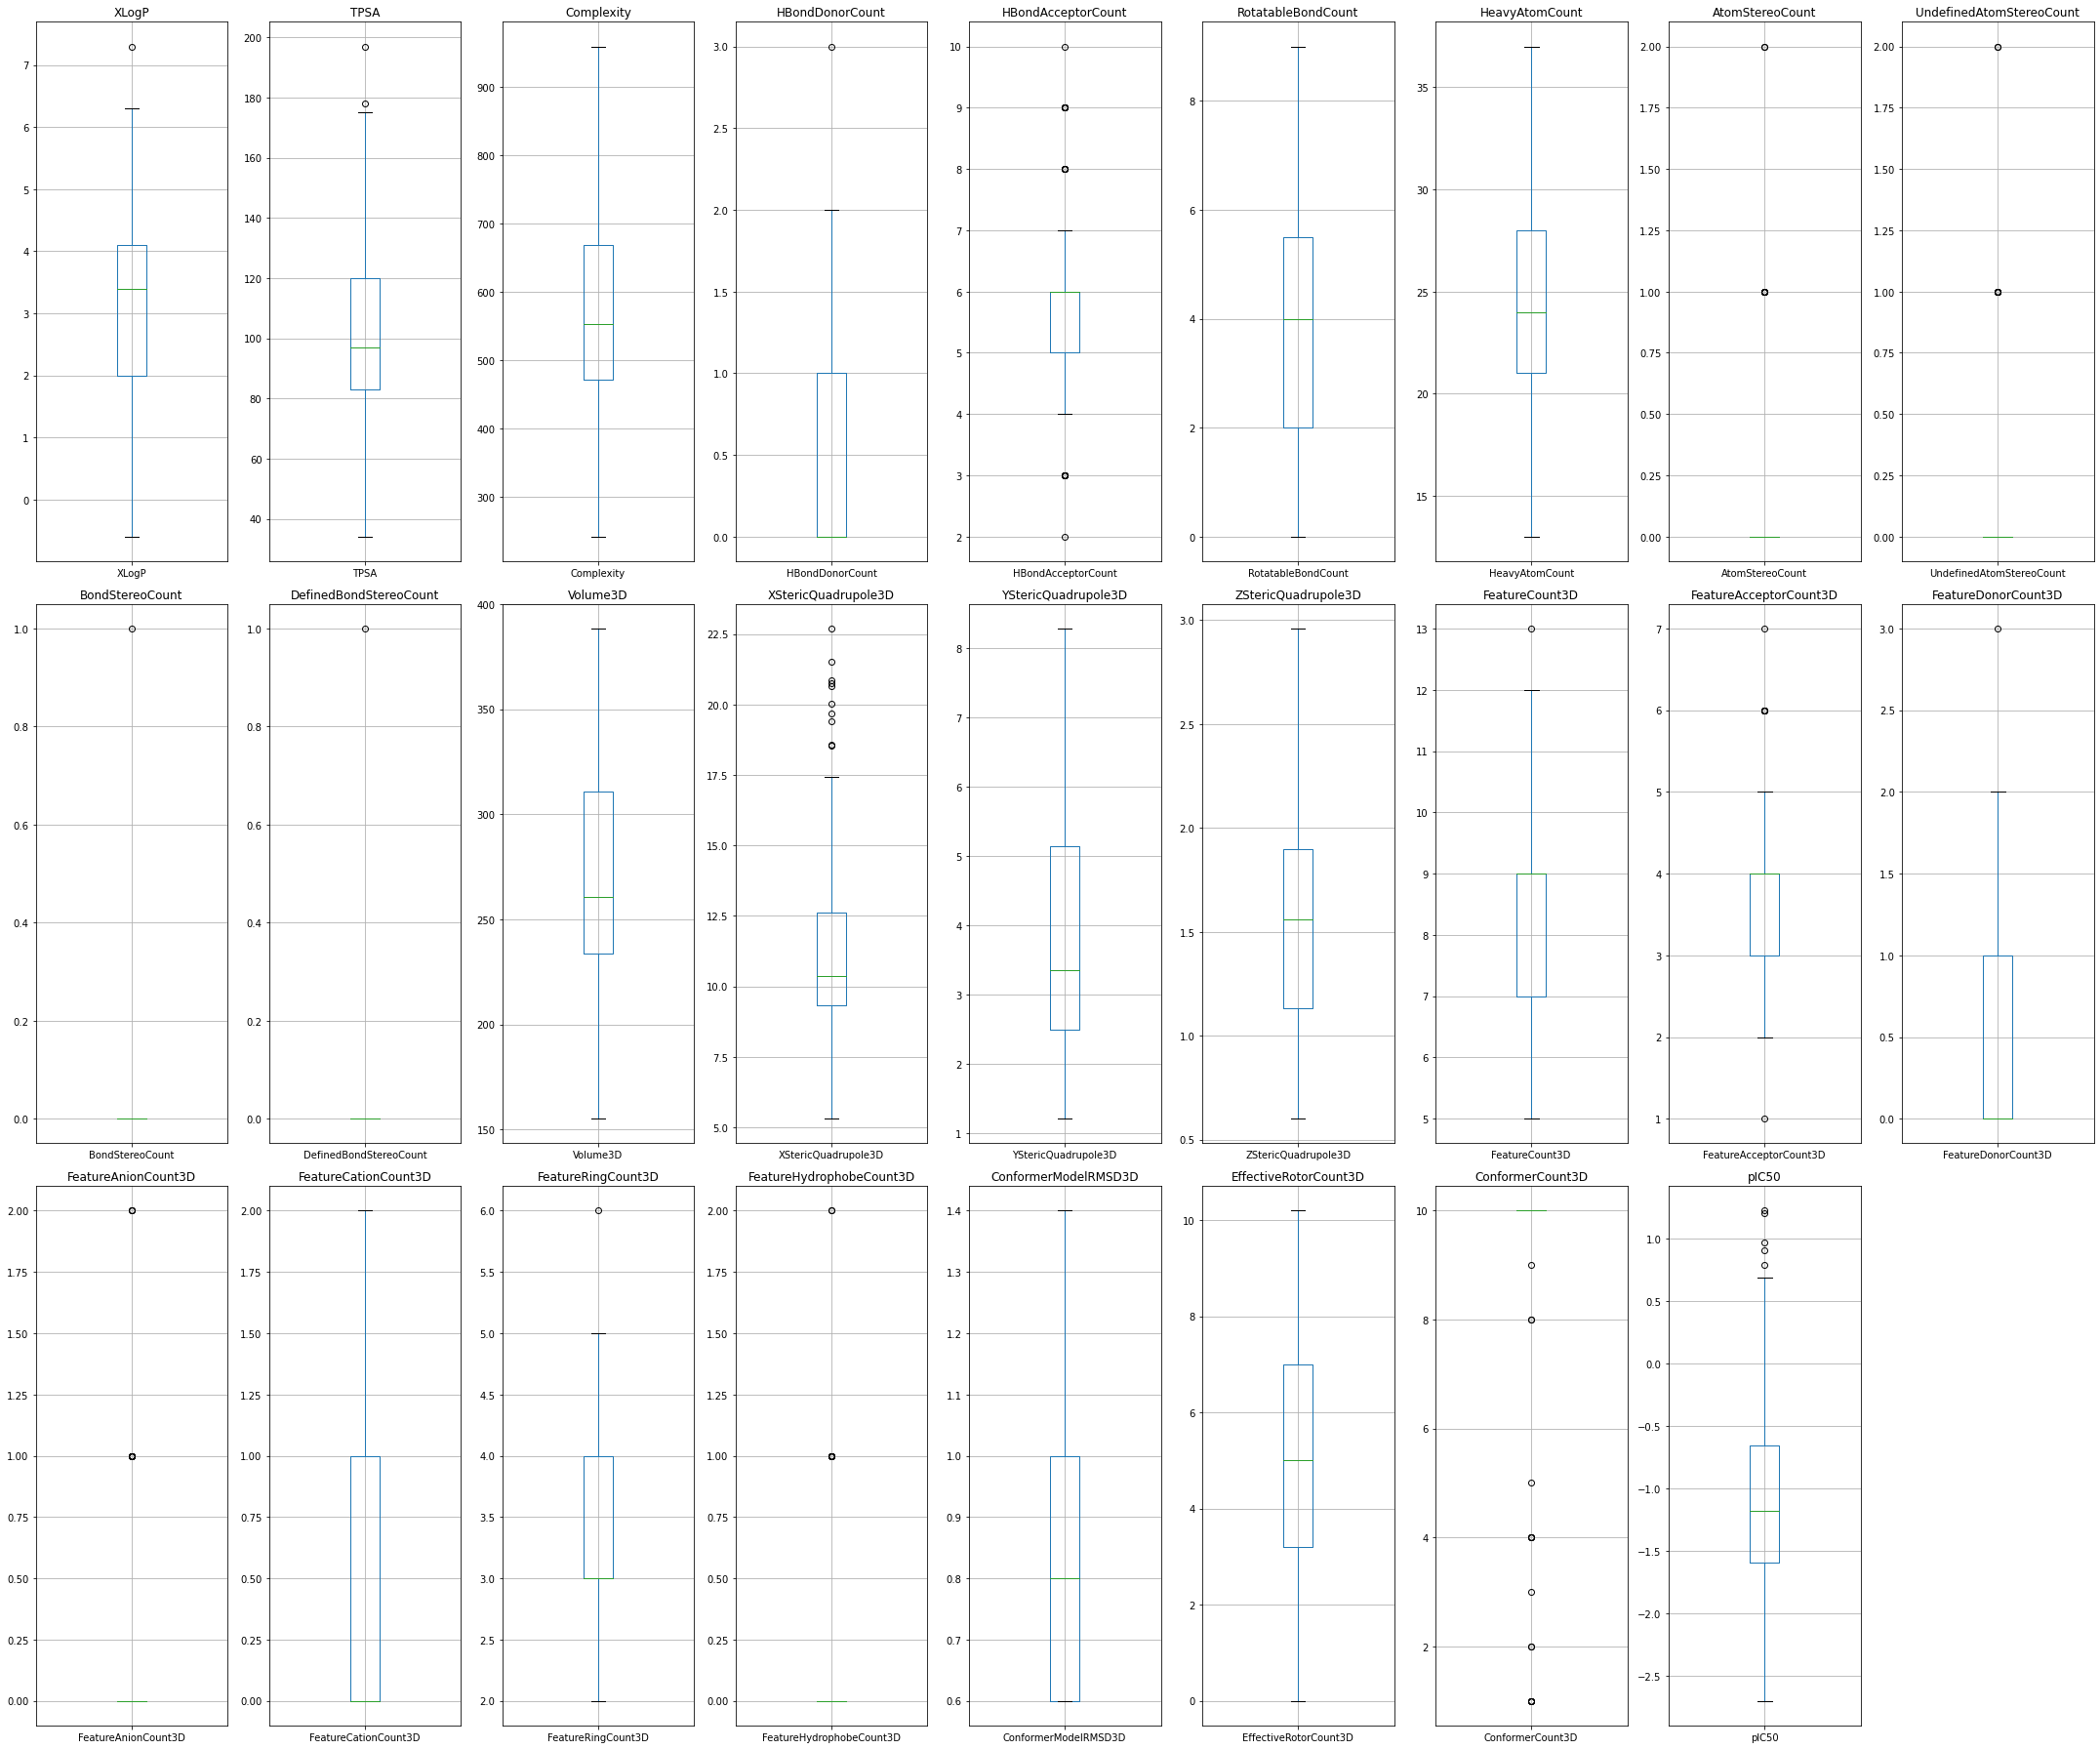

In [29]:
draw_boxplots(df2, df2.columns, 3, 9)

### Insights
The distributions for AtomStereoCount and UndefinedAtomStereoCount are the same, as are the distributions for BondStereoCount and DefinedBondStereoCount. 
Some features (FeatureHydrophobicCount, FeatureAnioncount, and the aforementioned features) only have two values throughout the entire dataset. Consider dropping these features to reduce bias in the model.

## Modeling with statsmodels

Since pIC50 and XLogP are the two most important features in this dataset for predicting drug efficacy, a basic linear model will correlate these two features to serve as a baseline model.

In [30]:
#basic model

logp_model = ols(formula='pIC50 ~ XLogP', data=df2).fit()
logp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1217
Date:                Mon, 28 Mar 2022   Prob (F-statistic):              0.728
Time:                        11:18:31   Log-Likelihood:                -119.10
No. Observations:                  91   AIC:                             242.2
Df Residuals:                      89   BIC:                             247.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1214      0.216     -5.181      0.000      -1.551      -0.691
XLogP          0.0213      0.061      0.349      0.728      -0.100       0.143
==============================================================================
Omnibus:                        4.429   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.089
Skew:                           0.519   Prob(JB):                        0.129
Kurtosis:                       3.048   Cond. No.                         8.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

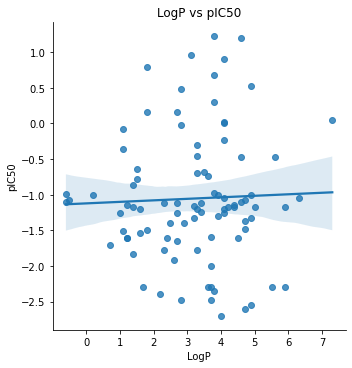

In [31]:
sns.lmplot(data=df2, x='XLogP', y='pIC50')
plt.xlabel('LogP')
plt.ylabel('pIC50')
plt.title('LogP vs pIC50');

### Insight
The lm plot along with the R-squared value in the basic model clearly shows the relationship between LogP and pIC50 is not linear. Multiple linear regression with additional features will be necessary to accurately predict blinded pIC50 values.

In [32]:
#constructing a model using all features
formula_2 = ('pIC50 ~ XLogP +TPSA + Complexity + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + HeavyAtomCount + AtomStereoCount + UndefinedAtomStereoCount + BondStereoCount + DefinedBondStereoCount + Volume3D + XStericQuadrupole3D + YStericQuadrupole3D + ZStericQuadrupole3D + FeatureCount3D + FeatureAcceptorCount3D + FeatureDonorCount3D + FeatureAnionCount3D + FeatureCationCount3D + FeatureRingCount3D + FeatureHydrophobeCount3D + ConformerModelRMSD3D + EffectiveRotorCount3D + ConformerCount3D')

all_model = ols(formula=formula_2, data=df2).fit()
all_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     4.460
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           1.03e-06
Time:                        11:18:32   Log-Likelihood:                -78.522
No. Observations:                  91   AIC:                             203.0
Df Residuals:                      68   BIC:                             260.8
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9451      0.884     -3.333      0.001      -4.708      -1.182
XLogP                        0.1827      0.119      1.537      0.129      -0.055       0.420
TPSA                        -0.0121      0.008     -1.485      0.142      -0.028       0.004
Complexity                  -0.0029      0.002     -1.364      0.177      -0.007       0.001
HBondDonorCount             -0.7961      0.637     -1.250      0.216      -2.067       0.475
HBondAcceptorCount           0.1796      0.140      1.282      0.204      -0.100       0.459
RotatableBondCount           0.3035      0.194      1.563      0.123      -0.084       0.691
HeavyAtomCount              -0.0285      0.220     -0.130      0.897      -0.468       0.411
AtomStereoCount             -0.0550      0.098     -0.560      0.577      -0.251       0.141
UndefinedAtomStereoCount    -0.0550      0.098     -0.560      0.577      -0.251       0.141
BondStereoCount             -0.5271      0.357     -1.477      0.144      -1.239       0.185
DefinedBondStereoCount      -0.5271      0.357     -1.477      0.144      -1.239       0.185
Volume3D                     0.0093      0.016      0.570      0.570      -0.023       0.042
XStericQuadrupole3D          0.0295      0.036      0.819      0.416      -0.042       0.101
YStericQuadrupole3D          0.0675      0.151      0.446      0.657      -0.234       0.369
ZStericQuadrupole3D          0.2973      0.249      1.194      0.237      -0.200       0.794
FeatureCount3D               0.1578      0.181      0.873      0.386      -0.203       0.518
FeatureAcceptorCount3D       0.1474      0.188      0.785      0.435      -0.227       0.522
FeatureDonorCount3D          0.7871      0.576      1.366      0.176      -0.363       1.937
FeatureAnionCount3D          0.4043      0.297      1.363      0.177      -0.188       0.996
FeatureCationCount3D        -0.6166      0.269     -2.290      0.025      -1.154      -0.079
FeatureRingCount3D          -0.1507      0.225     -0.671      0.504      -0.599       0.297
FeatureHydrophobeCount3D    -0.4137      0.239     -1.730      0.088      -0.891       0.064
ConformerModelRMSD3D        -0.6595      0.866     -0.761      0.449      -2.388       1.069
EffectiveRotorCount3D       -0.5729      0.174     -3.296      0.002      -0.920      -0.226
ConformerCount3D             0.1496      0.045      3.359      0.001       0.061       0.238
==============================================================================
Omnibus:                        0.281   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.366
Skew:                          -0.126   Prob(JB):                        0.833
Kurtosis:                       2.819   Cond. No.                     

### Insight:
all_model has strong multicolllinearity issues. This is not surprising, considering that the correlation heatmap shows this numerically. Features that are collinear (r2 > 0.7) with 3 or more other features will be dropped to see if the model is improved. Additionally, features that only have 1 or 2 values will be dropped as well.

In [33]:
#list of features that are collinear with three or more other features, or only have 1-2 values. list is just for reference

Multicorr = ['YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D', 'Complexity',
            'HeavyAtomCount', 'AtomStereoCount','UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount',
            'FeatureAnionCount3D', 'FeatureHydrophobeCount3D']

In [34]:
formula_3 = ('pIC50 ~ XLogP + TPSA + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + XStericQuadrupole3D + ZStericQuadrupole3D + FeatureCount3D + FeatureAcceptorCount3D + FeatureDonorCount3D + FeatureCationCount3D + FeatureRingCount3D + ConformerCount3D')

model2 = ols(formula=formula_3, data=df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     4.814
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           4.67e-06
Time:                        11:18:32   Log-Likelihood:                -92.096
No. Observations:                  91   AIC:                             212.2
Df Residuals:                      77   BIC:                             247.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.0138      0.661     -3.044      0.003      -3.331      -0.697
XLogP                      0.2463      0.095      2.594      0.011       0.057       0.435
TPSA                   -4.119e-06      0.005     -0.001      0.999      -0.010       0.010
HBondDonorCount            0.2560      0.581      0.440      0.661      -0.901       1.413
HBondAcceptorCount        -0.0128      0.095     -0.135      0.893      -0.201       0.176
RotatableBondCount        -0.2389      0.089     -2.678      0.009      -0.416      -0.061
XStericQuadrupole3D        0.0415      0.025      1.669      0.099      -0.008       0.091
ZStericQuadrupole3D       -0.0218      0.203     -0.107      0.915      -0.426       0.383
FeatureCount3D            -0.2290      0.186     -1.228      0.223      -0.600       0.142
FeatureAcceptorCount3D     0.4549      0.254      1.790      0.077      -0.051       0.961
FeatureDonorCount3D       -0.3295      0.567     -0.581      0.563      -1.458       0.799
FeatureCationCount3D       0.0852      0.314      0.271      0.787      -0.541       0.711
FeatureRingCount3D        -0.0773      0.169     -0.457      0.649      -0.414       0.260
ConformerCount3D           0.1387      0.044      3.182      0.002       0.052       0.225
==============================================================================
Omnibus:                        0.259   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.028
Skew:                          -0.001   Prob(JB):                        0.986
Kurtosis:                       3.085   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Insight

Model has improved R2 vs the previous models, but still suffers from multicollinearity. For the next model, only features from model2 where p<0.1 will be included in the formula.

In [35]:
#only including features from model2 in the formula where p<0.1

formula_5 = 'pIC50 ~ XLogP + RotatableBondCount + FeatureAcceptorCount3D + ConformerCount3D + XStericQuadrupole3D'

model4 = ols(formula=formula_5, data=df2).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     8.650
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           1.17e-06
Time:                        11:18:32   Log-Likelihood:                -100.45
No. Observations:                  91   AIC:                             212.9
Df Residuals:                      85   BIC:                             228.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.1700      0.564     -5.623      0.000      -4.291      -2.049
XLogP                      0.2300      0.072      3.208      0.002       0.087       0.373
RotatableBondCount        -0.3308      0.055     -5.993      0.000      -0.441      -0.221
FeatureAcceptorCount3D     0.2315      0.085      2.737      0.008       0.063       0.400
ConformerCount3D           0.1480      0.039      3.810      0.000       0.071       0.225
XStericQuadrupole3D        0.0432      0.023      1.883      0.063      -0.002       0.089
==============================================================================
Omnibus:                        3.341   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.043
Skew:                           0.448   Prob(JB):                        0.218
Kurtosis:                       2.995   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


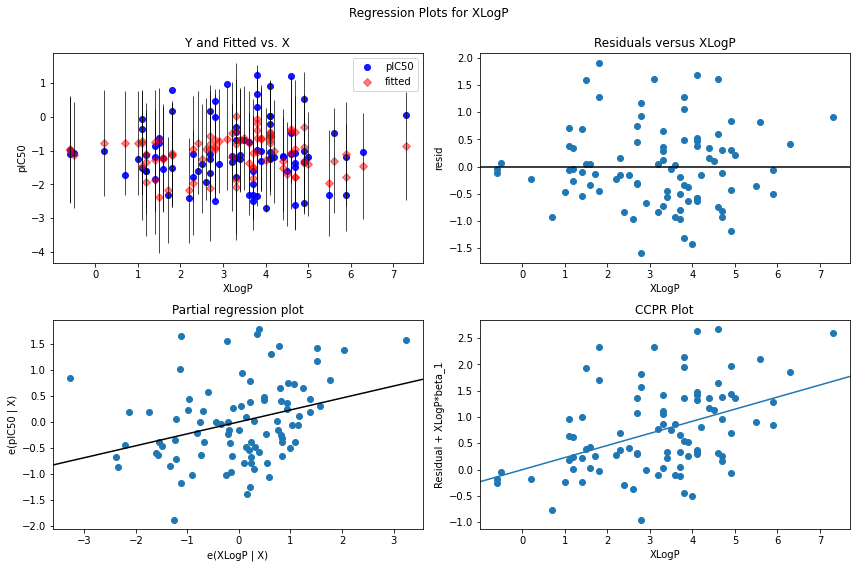

In [36]:
#does this model follow assumptions of linear regression?

sm.graphics.plot_regress_exog(model4, 'XLogP', fig=plt.figure(figsize=(12, 8)));

eval_env: 1


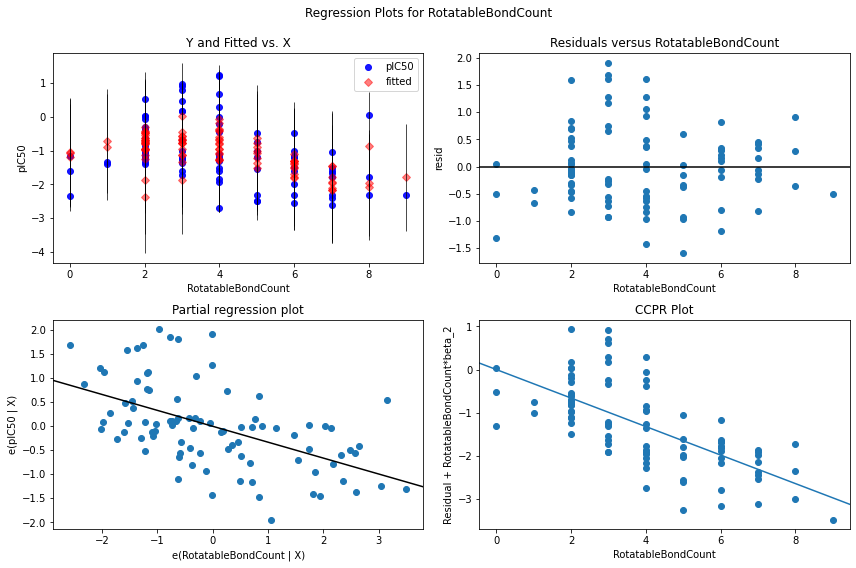

In [37]:
sm.graphics.plot_regress_exog(model4, 'RotatableBondCount', fig=plt.figure(figsize=(12, 8)));

eval_env: 1


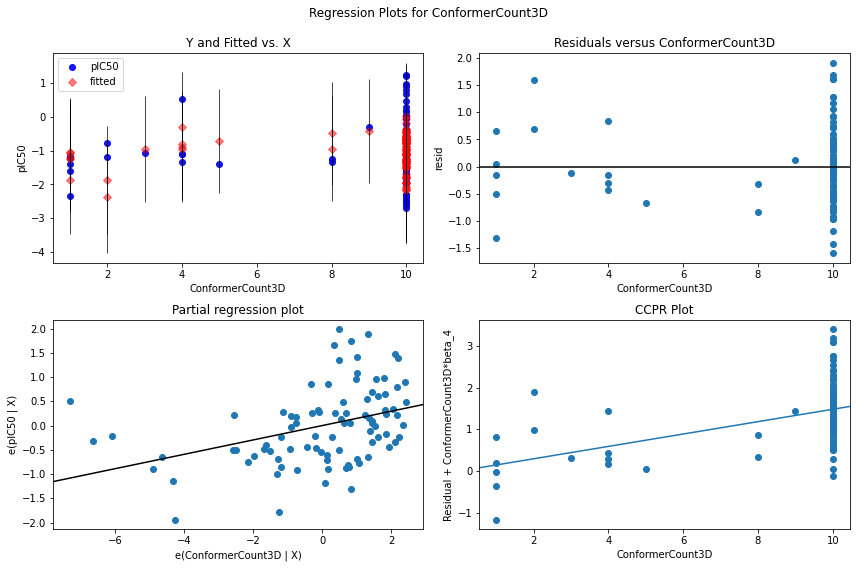

In [38]:
sm.graphics.plot_regress_exog(model4, 'ConformerCount3D', fig=plt.figure(figsize=(12, 8)));

eval_env: 1


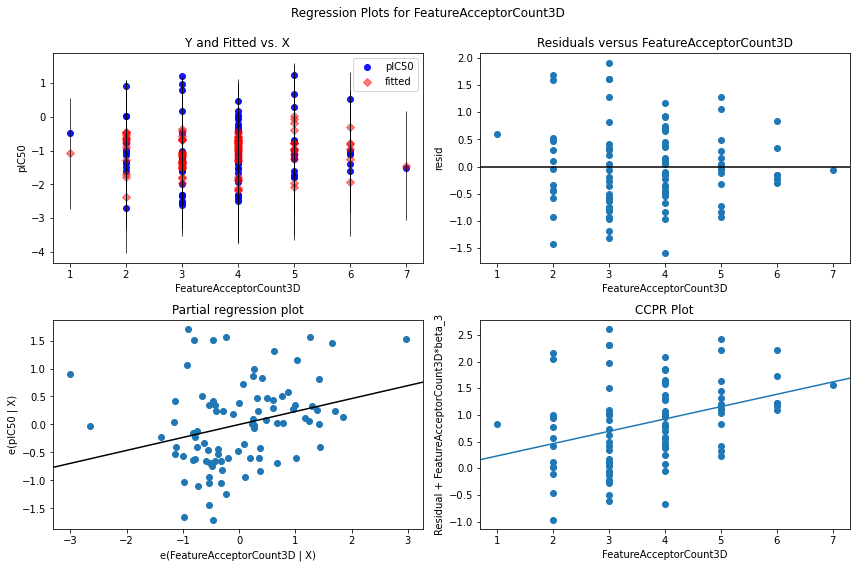

In [39]:
sm.graphics.plot_regress_exog(model4, 'FeatureAcceptorCount3D', fig=plt.figure(figsize=(12, 8)));

### Does the model follow the assumptions of linear regression?
<ul>
<li>Durbin-Watson value indicates positive autocorrelation and that the errors are independent.</li>
<li>Omnibus value indicates residuals are not normally distributed.</li>
<li>R2 value is 0.337, indicating the relationship is not linear.</li>
<li>Error residual plots show homoskedastic trends.</li>
</ul>

**Additionally**:
<ul>
<li>Skew statistic indicates the data for this model isn't skewed</li>
<li>Kurtosis value indicates the data is too peaked, and therefore non-normal</li>
</ul>

Given these observations, these linear regression models might not be the best models for pIC50 predictions since the data and errors do not follow some of the assumptions of linear regression (linearity and normal distribution of errors are violated). Will attempt to use cross validation and regularization techniques (ridge, lasso, etc) to yield a better model.

## Modeling with sklearn: Ridge, lasso, elasticnet 

#### Dummy model

In [40]:
df2.head()

,XLogP,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,AtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,5.6,121.0,559.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121
2821293,4.9,126.0,670.0,1.0,9.0,6.0,33.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1.000000
2820912,6.3,175.0,627.0,1.0,8.0,7.0,32.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041393
2744846,4.4,162.0,554.0,1.0,8.0,6.0,29.0,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128
2745617,4.4,106.0,529.0,1.0,6.0,6.0,29.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091


In [41]:
#creating X and y, performing tts for sklearn linear regression 

todrop =['pIC50', 'YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D', 'TPSA',
        'Complexity', 'FeatureDonorCount3D']

y = df2[['pIC50']]
X = df2.drop(todrop, axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [43]:
#creation of baseline dummy regressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dy_pred = dummy.predict(X_train)
dy_pred_test = dummy.predict(X_test)

In [44]:
dummy.score(X_train, y_train)

0.0

### Linear Regression model

In [71]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

lr=LinearRegression()

In [72]:
cv_results = cross_validate(
                X=X, 
                y=y,
                estimator=lr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

In [73]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error'])

In [74]:
# Compare the results
print(-1*cv_results.get('train_neg_mean_squared_error').mean(),
      cv_results.get('train_neg_mean_squared_error').std())

0.3870603260414516 0.032089591105961573


In [75]:
print(-1*cv_results.get('test_neg_mean_squared_error').mean(),
      cv_results.get('test_neg_mean_squared_error').std())

0.7391849126020354 0.3791987128799793


In [77]:
lr.fit(X, y)
lr.score(X, y)

0.5015125503227507

In [84]:
print(cv_results.get('train_r2').mean())
print(cv_results.get('test_r2').mean())


0.5134412381568924
-2.8796343393739354


### Ridge regressor

In [88]:
#ridge regressor on train set
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
ridmod = Ridge(alpha=1.0, random_state=42)
ridmod.fit(X_train_scaled, y_train)

ridmod.score(X_train_scaled, y_train)


0.5331525353214497

In [93]:
cv_results2 = cross_validate(X=X_train_scaled, y=y_train, estimator=ridmod, cv=10, 
                             scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [94]:
cv_results2['train_r2']

array([0.58217857, 0.59502897, 0.54925473, 0.55481742, 0.54457493,
       0.50980669, 0.53848036, 0.54239829, 0.50453125, 0.56347911])

In [95]:
cv_results2['test_r2']

array([-0.73733258, -3.98423671, -0.12292312, -0.24732957,  0.13722909,
        0.42749702, -0.46592081,  0.2169356 ,  0.60814194,  0.19697722])

In [96]:
y_pred = ridmod.predict(X_test_scaled)

In [97]:
ridmod.score(X_test_scaled, y_test)

0.029465924178617042

In [98]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_pred, y_test))

0.6679103329031313

In [100]:
cv_results2['test_neg_mean_squared_error'].mean()

-0.7577667660186485

## Random Forest Regressor

In [101]:
#randomforeset regressor model

rfr = RandomForestRegressor(random_state=234)
rfr.fit(X_train_scaled, y_train)
y_pred3 = rfr.predict(X_test_scaled)
print("R2 for training RF model: ", rfr.score(X_train_scaled, y_train))
print("R2 for testing RF model: ", rfr.score(X_test_scaled, y_test))

R2 for training RF model:  0.8932990532840691
R2 for testing RF model:  -0.07105118176848091


C:\Users\Adonis McQueen\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [102]:
#feature ranking
rfr.feature_importances_

array([0.08495741, 0.1665828 , 0.02918296, 0.1401978 , 0.06719843,
       0.00633333, 0.00684195, 0.        , 0.        , 0.14145104,
       0.12008146, 0.09958421, 0.01853603, 0.02459724, 0.02055561,
       0.03927942, 0.01956527, 0.01505501])

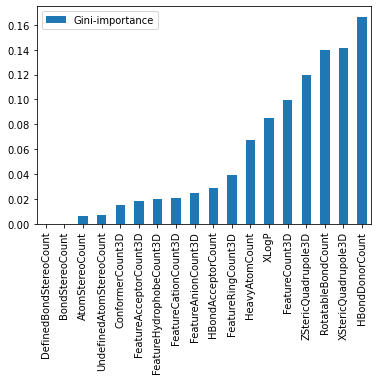

In [103]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90);

### Insight
The RandomForestRegressor is overfitting to the training data, but has the highest R2 score out of the models tested. The dataset will be modified to include the top 10 features from the feature importance plot.

In [104]:
importances['Gini-importance'].sort_values(ascending=False)

HBondDonorCount             0.166583
XStericQuadrupole3D         0.141451
RotatableBondCount          0.140198
ZStericQuadrupole3D         0.120081
FeatureCount3D              0.099584
XLogP                       0.084957
HeavyAtomCount              0.067198
FeatureRingCount3D          0.039279
HBondAcceptorCount          0.029183
FeatureAnionCount3D         0.024597
FeatureCationCount3D        0.020556
FeatureHydrophobeCount3D    0.019565
FeatureAcceptorCount3D      0.018536
ConformerCount3D            0.015055
UndefinedAtomStereoCount    0.006842
AtomStereoCount             0.006333
BondStereoCount             0.000000
DefinedBondStereoCount      0.000000
Name: Gini-importance, dtype: float64

In [53]:
todrop2 =['pIC50', 'YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D', 'TPSA',
        'Complexity', 'FeatureDonorCount3D', 'FeatureCationCount3D', 'FeatureHydrophobeCount3D', 'FeatureAcceptorCount3D',
         'ConformerCount3D', 'UndefinedAtomStereoCount', 'AtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount']

y2 = df2[['pIC50']]
X2 = df2.drop(todrop2, axis=1)

In [54]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [55]:
RFR2 = RandomForestRegressor(random_state=42)
RFR2.fit(X_train2, y_train2)
y_pred4 = RFR2.predict(X_test2)
print("R2 for training RF model: ", RFR2.score(X_train2, y_train2))
print("R2 for testing RF model: ", RFR2.score(X_test2, y_test2))

R2 for training RF model:  0.8961466550948554
R2 for testing RF model:  -0.15783297467650836


C:\Users\Adonis McQueen\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [85]:
RFR2.feature_importances_

array([0.08528093, 0.18124367, 0.03785095, 0.14112452, 0.08957929,
       0.16901903, 0.15310571, 0.08628737, 0.02443332, 0.03207522])

In [57]:
cmpd_A = pcp.Compound.from_cid(2744814)
print(cmpd_A.molecular_formula)
print(cmpd_A.iupac_name)

C21H14Cl2N4OS2
N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thiazol-4-yl)pyrimidin-2-yl]sulfanylacetamide


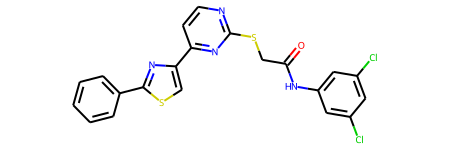

In [58]:


Chem.MolFromSmiles(df.SMILES[0])

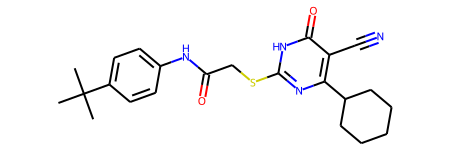

In [59]:
Chem.MolFromSmiles(df.SMILES[24])